In [2]:
# Dance to import our kmeans model
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from k_means import KMeans
from voronoi_processing import get_polygons, interpolate_centroid_history

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs

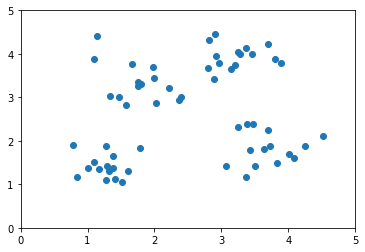

In [9]:
# data, _ = make_blobs(60, cluster_std=[0.3, 0.4, 0.4, 0.3], center_box=[0.5, 4.5], 
#                      centers=[[1.3, 1.2], [1.8, 3.4], [3.4, 4], [3.8, 1.8]])
data = np.load("data/synth_data.npy")

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.scatter(data[:, 0], data[:, 1])

In [10]:
# centroid_original = KMeans(4, centroid_init="kmeans++", verbose=True)
# centroid_original.fit(data)
# centroid_history = interpolate_centroid_history(centroid_original.centroid_history, 70, 2)

centroid_history = np.load("data/centroid_history1.npy")

In [ ]:
cmap = plt.get_cmap("jet")
colors = [
    cmap(0.25),
    cmap(0.45),
    cmap(0.75),
    cmap(0.9),
]

fig = plt.figure()
plt.xlim(0, 5)
plt.ylim(0, 5)
camera = Camera(fig)
for i in range(len(centroid_history)):
# for i in range(1):
    polygons = get_polygons(centroid_history[i], [0, 5], [0, 5])
    labels = centroid_original._get_labels(data, centroid_history[i])
    for j, p in enumerate(polygons):
        
        color = colors[j]
        
        plt.scatter(data[labels==j, 0], data[labels==j, 1], color=color, s=15)
        plt.fill(p[:, 0], p[:, 1], c=color, alpha=0.5, edgecolor="black")
        plt.scatter(centroid_history[i][j, 0], centroid_history[i][j, 1], s=60, color=color, edgecolor="black")
        
    camera.snap()

animation = camera.animate()
animation.save("/Users/jacobbumgarner/Desktop/b.mp4", fps=30, dpi=150,
               progress_callback=lambda x, _: print(f"`Frame: {x}/{len(centroid_history)}", end="\r"))

In [ ]:
np.save("data/synth_data.npy", data)
np.save("data/centroid_history2.npy", centroid_history)

### Cumulative Distribution Function
In the cells below, I visualize the random selection of a value from a probability
distribution using the cumulative distribution function.

This a highly simply yet beautiful function!

<BarContainer object of 60 artists>

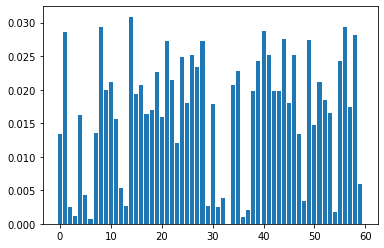

In [11]:

lengths = cdist([centroid_history[0, 0]], data)[0]
lengths /= lengths.sum()
plt.bar(np.arange(lengths.shape[0]), lengths)

0.20947541670770375


<BarContainer object of 1 artists>

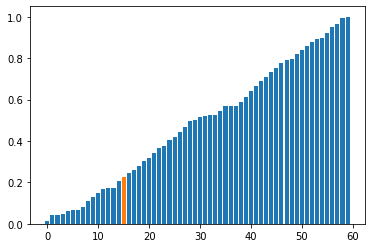

In [12]:
selection = lengths.cumsum()
selection /= selection[-1]
plt.bar(np.arange(selection.shape[0]), selection)
sample = np.random.random_sample()
print(sample)
idx = selection.searchsorted(sample, side="right")
plt.bar(idx, selection[idx])

<BarContainer object of 1 artists>

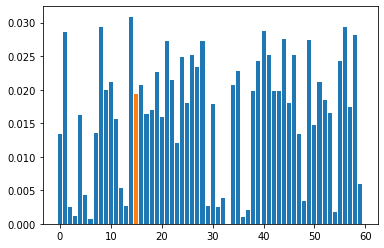

In [13]:
lengths = cdist([centroid_history[0, 0]], data)[0]
lengths /= lengths.sum()
plt.bar(np.arange(lengths.shape[0]), lengths)
plt.bar(idx, lengths[idx])

### Bee K-Means centroid history interpolation for manim

In [20]:
bee_history = np.load("label_videos/centroid_history.npy")
interpolated_history = interpolate_centroid_history(bee_history, 9*30)  # 1s per step
np.save("label_videos/interpolated_centroid_history.npy", interpolated_history)

In [22]:
print(interpolated_history.shape[1])

8
